# NHL MVP Analysis

This project is a first foray into machine learning. The goal is to predict player's vote share of the Hart trophy, which is awarded to the most valuable player in the National Hockey League as voted on by members of the Professional Hockey Writer's Association.  

Hockey statistics come from Evolving Hockey and Hockey-Reference. At the moment only basic statistics provided in the Hart trophy candidates by year summary page from Hockey-Reference are used. A medium term goal is to scrape data including advanced statistics to combine with the existing data. As it will turn out, prediction performance based only on the basic statistics used to far is not very good. 

References/Acknowledgements:
Most of what appears in this notebook was learned/borrowed from Kaggle. In particular, two specific notebooks I heavily referenced are https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python and https://www.kaggle.com/mmueller/stacking-starter.

In [1]:
# imports
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import os
import time
import csv 
import sklearn
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import warnings

import xgboost as xgb

from sklearn.ensemble import (RandomForestRegressor,  ExtraTreesRegressor)
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.model_selection import (KFold, train_test_split, cross_val_score)
from sklearn.metrics import (mean_absolute_error)
from sklearn.pipeline import make_pipeline

from xgboost import XGBRegressor
from bs4 import BeautifulSoup


warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

%matplotlib inline
py.init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
try:
    full_data= pd.read_csv("hockey-data-hart.csv")    
except:
    # Scrape data
    # specify the url
    years = range(1936,2018 + 1)
    addresses = ["https://www.hockey-reference.com/awards/voting-{}.html#all-hart-stats".format(yr) for yr in years]
    names = ['Year',  
             'player',
             'age',
             'team_id',
             'pos',
             'votes',
             'pct_of_vote',
             'first',
             'second',
             'third',
             'fourth',
             'fifth',
             'goals',
             'assists',
             'points',
             'plus_minus',
             'wins_goalie',
             'losses_goalie',
             'ties_goalie',
             'goals_against_avg',
             'save_pct',
             'ops',
             'dps',
             'gps',
             'ps']

    with open('hockey-data-hart.csv', 'w') as csvfile:    #Create the csv file
        hockeywriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
        hockeywriter.writerow(names)
        for i, pg in enumerate(addresses):
            time.sleep(0.1) #pause the code for a sec
            r = requests.get(pg)
            # parse the html using beautiful soup and store in variable `soup`
            soup = BeautifulSoup(r.text, "html.parser")
            values = [years[i]]  #first value

            #Go through the stats and add them to a list
            for tag in soup.findAll("td"):
                if tag.string == 'None': #don't save 'None' string
                    values.append('') 
                elif tag['data-stat']=='team_id': #use proper team name
                    try: #though it may not exist
                        values.append(tag.contents[0]['title'])
                    except:
                        values.append(tag.string)
                else:
                    values.append(tag.string)
                if tag['data-stat']=='ps': #if last value in row start on next line
                    hockeywriter.writerow(values)
                    values = [years[i]]  #set first value again     

In [3]:
full_data= pd.read_csv("hockey-data-hart.csv")    


# clean it up
full_data=full_data.dropna(axis=0,subset=['pct_of_vote'])
full_data=full_data.drop(['first','second','third','fourth','fifth'],axis=1)
full_data = full_data[full_data["pct_of_vote"]>0]

# let's also drop goalies who are missing save pct, and skaters who are missing plus_minus
full_data = full_data.loc[~((full_data.pos=="G") & full_data.save_pct.isna())]
full_data = full_data.loc[~((full_data.pos!="G") & full_data.plus_minus.isna())]

# remaining na's should be due to mismatched position with stats. set them to zero
full_data = full_data.fillna(0)

# for non goalies (goalies), let's replace all goalie (non goalie) stats by zero rather than NaN

# Create a new feature p_simp: for players who have joint positions, we just keep the first one
def pos_combine(name):
    title_search = re.search('(^[A-Z]{1,2})', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

full_data["pos"] = full_data["pos"].apply(pos_combine)
full_data = full_data[full_data["pct_of_vote"]>1]

skaters = full_data[full_data['pos']!='G']
goalies = full_data[full_data['pos']=='G']
   
full_data.tail(20)

,Year,player,age,team_id,pos,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps
1021,2017,Sidney Crosby,29,Pittsburgh Penguins,C,1104,66.11,44,45,89,17.0,0.0,0.0,0.0,0.00,0.000,10.5,1.7,0.0,12.3
1022,2017,Sergei Bobrovsky,28,Columbus Blue Jackets,G,469,28.08,0,0,0,0.0,41.0,17.0,5.0,2.06,0.931,0.0,0.0,14.9,14.9
1023,2017,Brent Burns,31,San Jose Sharks,D,273,16.35,29,47,76,19.0,0.0,0.0,0.0,0.00,0.000,8.9,6.4,0.0,15.3
1024,2017,Erik Karlsson,26,Ottawa Senators,D,258,15.45,17,54,71,10.0,0.0,0.0,0.0,0.00,0.000,7.2,5.7,0.0,12.9
1025,2017,Patrick Kane,28,Chicago Blackhawks,RW,206,12.34,34,55,89,11.0,0.0,0.0,0.0,0.00,0.000,8.7,2.1,0.0,10.8
1026,2017,Brad Marchand,28,Boston Bruins,LW,184,11.02,39,46,85,18.0,0.0,0.0,0.0,0.00,0.000,9.8,2.8,0.0,12.6
1027,2017,Nikita Kucherov,23,Tampa Bay Lightning,RW,119,7.13,40,45,85,13.0,0.0,0.0,0.0,0.00,0.000,9.7,2.2,0.0,12.0
1028,2017,Nicklas Backstrom,29,Washington Capitals,C,60,3.59,23,63,86,17.0,0.0,0.0,0.0,0.00,0.000,7.8,2.1,0.0,9.9
1029,2017,Braden Holtby,27,Washington Capitals,G,19,1.14,0,0,0,0.0,42.0,13.0,6.0,2.07,0.925,0.0,0.0,12.3,12.3
1030,2017,Auston Matthews,19,Toronto Maple Leafs,C,17,1.02,40,29,69,2.0,0.0,0.0,0.0,0.00,0.000,8.2,1.5,0.0,9.7


              Year         age        votes  pct_of_vote       goals  \
count   579.000000  579.000000   579.000000   579.000000  579.000000   
mean   1992.274611   27.666667   135.754750    17.866269   28.241796   
std      16.597585    4.460644   251.766407    23.865447   20.736364   
min    1956.000000   18.000000     3.000000     1.010000    0.000000   
25%    1978.000000   24.500000    16.000000     2.490000    7.000000   
50%    1996.000000   27.000000    40.000000     7.140000   31.000000   
75%    2006.000000   30.000000   119.000000    21.865000   44.000000   
max    2018.000000   43.000000  1604.000000   100.000000   92.000000   

          assists      points  plus_minus  wins_goalie  losses_goalie  \
count  579.000000  579.000000  579.000000   579.000000     579.000000   
mean    42.701209   70.943005   18.642487     8.198618       4.519862   
std     28.990373   46.523371   21.215854    14.961205       8.534534   
min      0.000000    0.000000  -15.000000     0.000000     

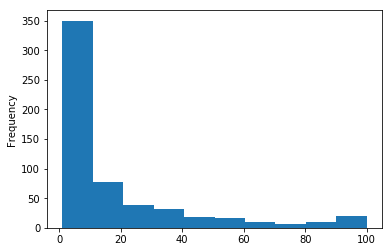

In [4]:
print(full_data.describe())
full_data['pct_of_vote'].plot.hist()

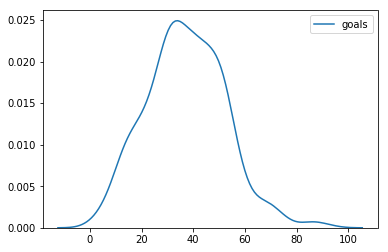

<Figure size 432x288 with 0 Axes>

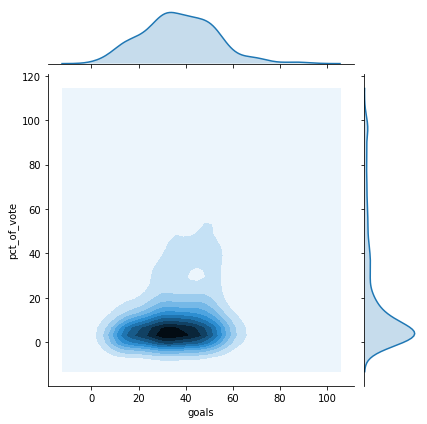

In [5]:
fig = plt.figure()
sns.kdeplot(skaters['goals'])
fig = plt.figure()
sns.jointplot(x='goals',y='pct_of_vote',data = skaters, kind='kde', gridsize=40)

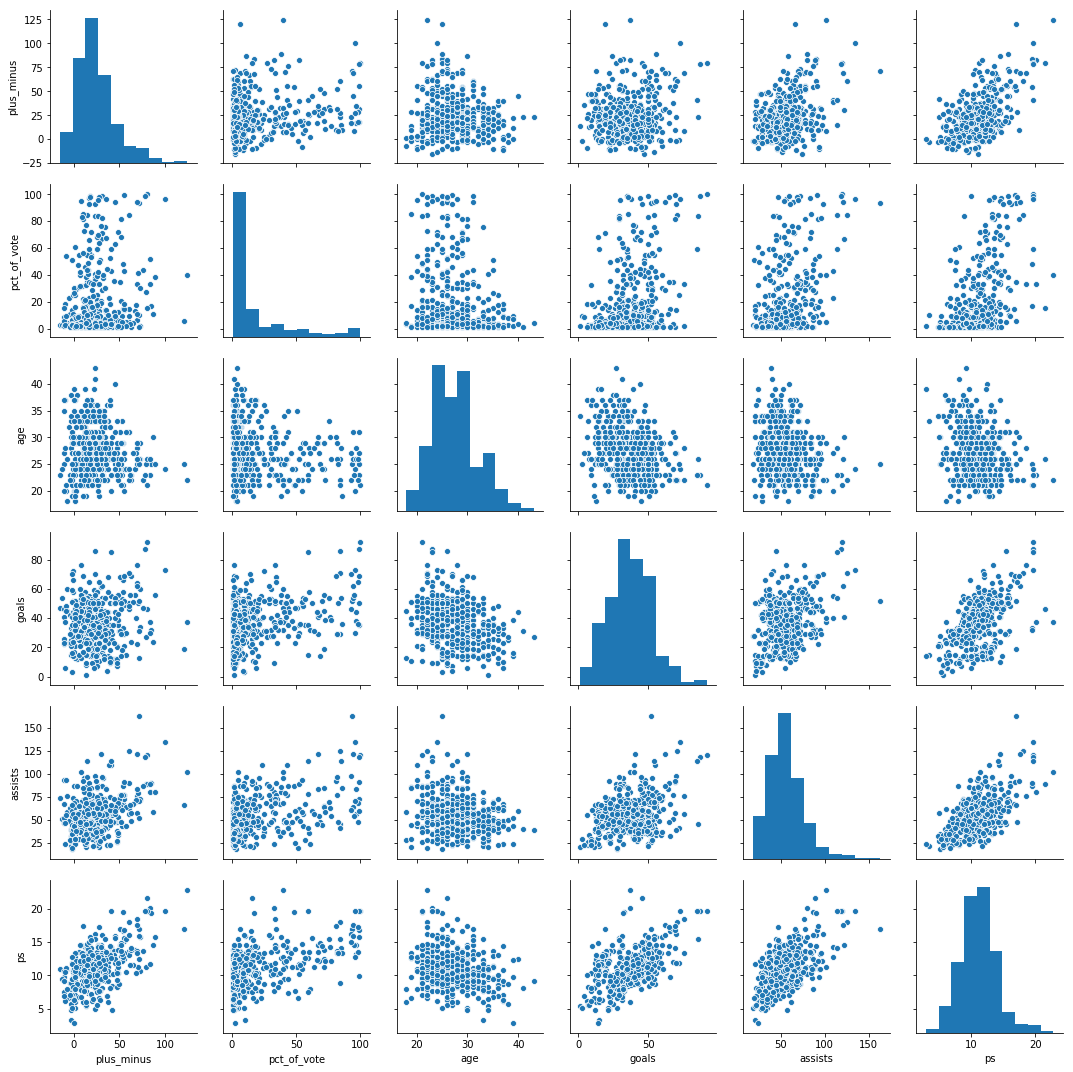

In [6]:
# examining some skater data
sns.pairplot(skaters[['plus_minus','pct_of_vote','age','goals', 'assists','ps']])

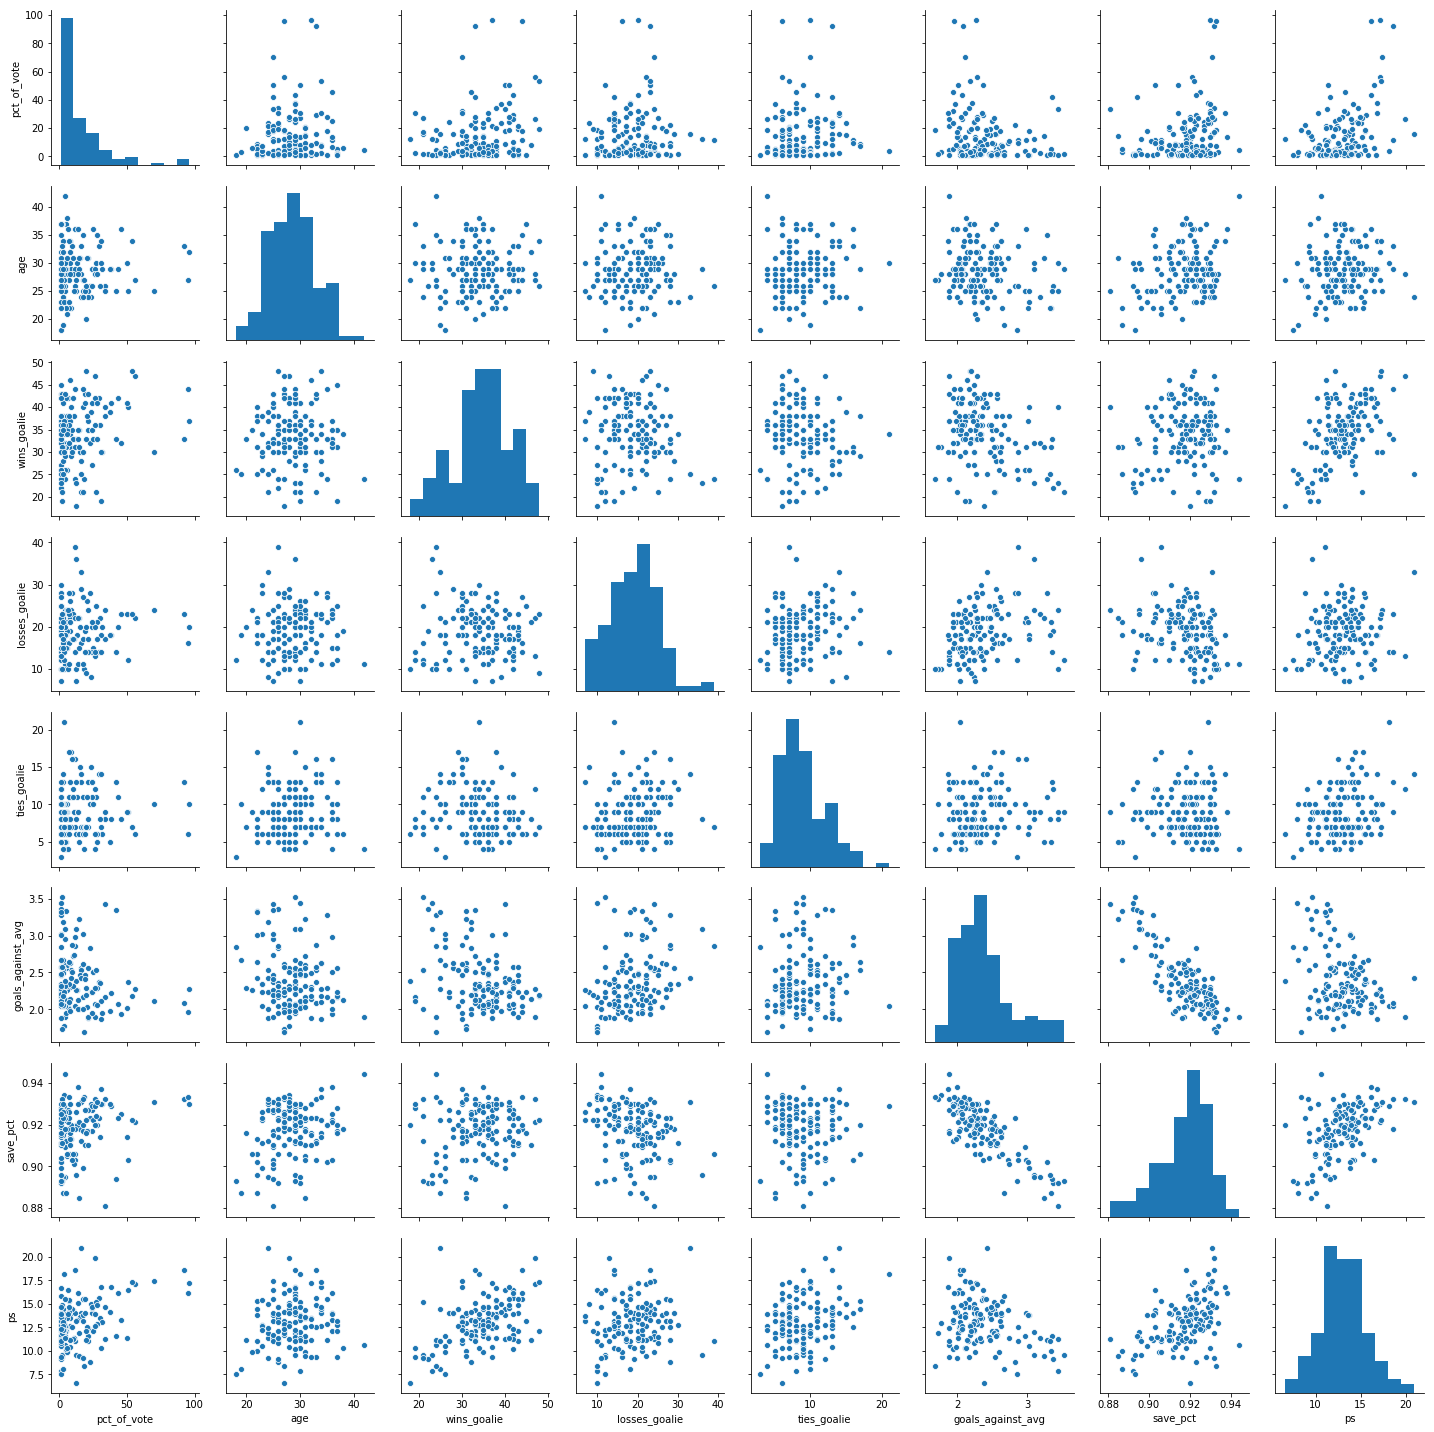

In [7]:
# examining some goalie data
sns.pairplot(goalies[['pct_of_vote','age','wins_goalie','losses_goalie','ties_goalie','goals_against_avg','save_pct','ps']])

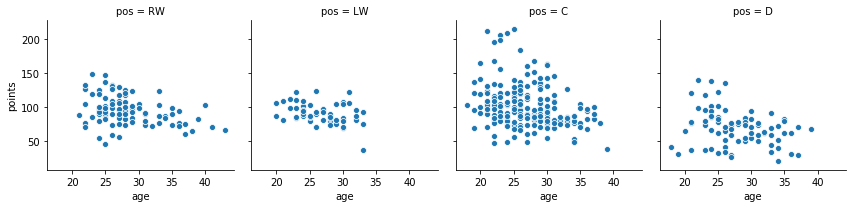

In [8]:
g = sns.FacetGrid(skaters,col="pos")
g.map(sns.scatterplot, 'age','points')

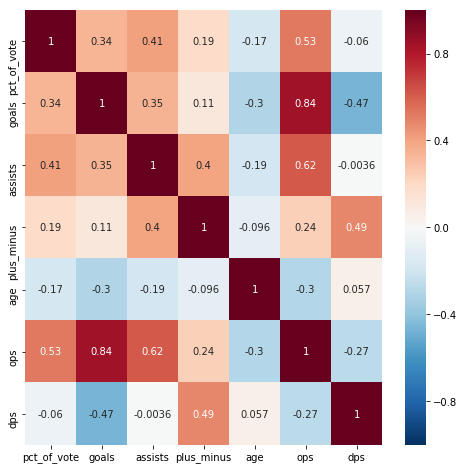

In [9]:
fd = skaters
features= ['pct_of_vote','goals','assists','plus_minus','age','ops','dps','pos']
fd = fd[features]
f = fd.corr()
plt.figure(figsize=(len(features),len(features)))

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

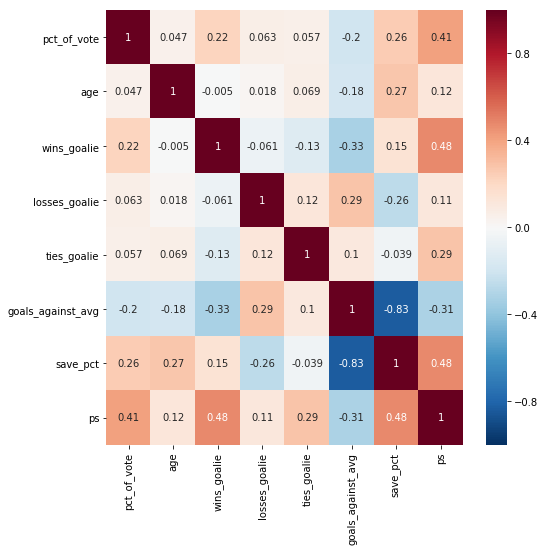

In [10]:
fd = goalies
features= ['pct_of_vote','age','wins_goalie','losses_goalie',
           'ties_goalie','goals_against_avg','save_pct','ps']
fd = fd[features]
f = fd.corr()
plt.figure(figsize=(len(features),len(features)));

sns.heatmap(f,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

We can expect from the plots above that directly fitting a model to the available data might be challenging. Nonetheless we will try anyways.

In [11]:
fd = full_data.copy()
# prepare for applying model:
# 1) preprocessing-scale
# t = fd.drop(["Year"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# fd[t.columns] = t
# actually its incorrect to preprocess the entire data set. this results in data contamination


# 2) one-hot encode positions
fd=pd.get_dummies(fd,columns=['pos'])

fd[fd["Year"]==2018]
# full_data.sample(10)
# fd.pct_of_vote.plot.hist()


,Year,player,age,team_id,votes,pct_of_vote,goals,assists,points,plus_minus,wins_goalie,losses_goalie,ties_goalie,goals_against_avg,save_pct,ops,dps,gps,ps,pos_C,pos_D,pos_G,pos_LW,pos_RW
1038,2018,Taylor Hall,26,New Jersey Devils,1264,77.07,39,54,93,14.0,0.0,0.0,0.0,0.0,0.0,9.9,2.3,0.0,12.2,0,0,0,1,0
1039,2018,Nathan MacKinnon,22,Colorado Avalanche,1194,72.80,39,58,97,11.0,0.0,0.0,0.0,0.0,0.0,10.0,2.2,0.0,12.2,1,0,0,0,0
1040,2018,Anze Kopitar,30,Los Angeles Kings,551,33.60,35,57,92,21.0,0.0,0.0,0.0,0.0,0.0,7.9,3.1,0.0,11.0,1,0,0,0,0
1041,2018,Claude Giroux,30,Philadelphia Flyers,546,33.29,34,68,102,28.0,0.0,0.0,0.0,0.0,0.0,9.0,2.8,0.0,11.8,1,0,0,0,0
1042,2018,Connor McDavid,21,Edmonton Oilers,270,16.46,41,67,108,20.0,0.0,0.0,0.0,0.0,0.0,10.5,2.6,0.0,13.1,1,0,0,0,0
1043,2018,Nikita Kucherov,24,Tampa Bay Lightning,166,10.12,39,61,100,15.0,0.0,0.0,0.0,0.0,0.0,9.8,1.8,0.0,11.6,0,0,0,0,1
1044,2018,Evgeni Malkin,31,Pittsburgh Penguins,97,5.91,42,56,98,16.0,0.0,0.0,0.0,0.0,0.0,10.2,2.2,0.0,12.4,1,0,0,0,0
1045,2018,Blake Wheeler,31,Winnipeg Jets,69,4.21,23,68,91,13.0,0.0,0.0,0.0,0.0,0.0,7.1,2.1,0.0,9.2,0,0,0,0,1
1046,2018,Alex Ovechkin,32,Washington Capitals,37,2.26,49,38,87,3.0,0.0,0.0,0.0,0.0,0.0,9.3,1.9,0.0,11.2,0,0,0,1,0
1047,2018,William Karlsson,25,Vegas Golden Knights,32,1.95,43,35,78,49.0,0.0,0.0,0.0,0.0,0.0,8.3,3.5,0.0,11.8,1,0,0,0,0


In [12]:


model_features = [ u'age', u'goals', u'assists',  u'plus_minus',
       u'wins_goalie', u'losses_goalie', u'ties_goalie', u'goals_against_avg',
       u'save_pct', u'ops', u'dps', u'gps', u'pos_C',
       u'pos_D', u'pos_G', u'pos_LW', u'pos_RW']

# Use all years 2015 and prior for training, and try to predict the previous three years.
target_yr = 2015
train=fd[fd["Year"]<=target_yr]
test=fd[fd["Year"] > target_yr]


# Prepare a holdout of the train set to use for blending. 
base, holdout = train_test_split(train,test_size=0.1)

x_test = test[model_features]
y_test = test.pct_of_vote

x_base = base[model_features]
y_base = base.pct_of_vote

x_holdout = holdout[model_features]
y_holdout = holdout.pct_of_vote


# x_base and y_base will be used to fit the base models
# then make predictions for y_holdout using x_holdout
# those predictions are used to train the stacker




# # scaling preprocessing the data. I'm not sure if it's actually a good idea to do this
# # Leave it out for now.

# t = x_base.drop(["pos_G"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# x_base[t.columns] = t

# t = x_holdout.drop(["pos_G"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# x_holdout[t.columns] = t

# t = x_test.drop(["pos_G"],axis=1).select_dtypes(exclude=["object"]).apply(sklearn.preprocessing.scale)
# x_test[t.columns] = t

In [13]:
# Wrapper class for sklearn models
# It trains on logarithmically renormalized vote_pct, rather than raw.
# This is because heuristically the vote share by player
# in any given year is approximately exponentially decaying
# so it made sense to me to try to make the data more regular by taking the log.
class SklearnWrapper(object):
    def __init__(self,clf,seed=0,params=None):
        params['random_state'] = seed
        self.clf = clf(**params)
        
        
    # automatically does log conversion in train and predict
    def train(self,x_train,y_train):
        self.clf.fit(x_train,np.log(y_train))
        
    def predict(self,x):
        return np.exp(self.clf.predict(x))
    
    def feature_importances(self):
        print(clf.feature_importances_)
        
def get_base_predictions(clf):

    clf.train(x_base,y_base)
    return clf.predict(x_holdout)
    
# Wrapper for xgboost from sklearn courtesy of https://www.kaggle.com/mmueller/stacking-starter
class XgbWrapper(object):
    def __init__(self, seed=0, params=None):
        self.param = params
        self.param['seed'] = seed
        self.nrounds = params.pop('nrounds', 250)

    def train(self, x_train, y_train):
        dtrain = xgb.DMatrix(x_train, label=np.log(y_train))
        self.gbdt = xgb.train(self.param, dtrain, self.nrounds)

    def predict(self, x):
        return np.exp(self.gbdt.predict(xgb.DMatrix(x)))
        

# SVR would require it's own wrapper but I don't use it below. 

In [14]:
#Try several models

# Put in our parameters. For now these values are the same as those in 
# https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

# Random Forest parameters
et_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': -1,
    'n_estimators': 100,
    'max_features': 0.6,
    'max_depth': 12,
    'min_samples_leaf': 2,
}


# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}


# Support Vector Classifier parameters 
sv_params = {
#     'kernel' : 'linear',
    'C' : 0.025
    }

mlp_params = {
    'hidden_layer_sizes': (4,4,2)
}

SEED = 0

# Train two versions of each model, one on vote_pct, and one on log_vote_pct
# for convenience, also generate predictions for the test data to use later

forest = SklearnWrapper(clf=RandomForestRegressor,seed=SEED,params=rf_params)
# print("Forest Regressor MAE on training data: %f"% mean_absolute_error(forest.predict(x_holdout),y_holdout))

gbm = SklearnWrapper(clf=XGBRegressor,seed=SEED,params=gb_params)
# print("XGBRegressor MAE on training data: %f"% mean_absolute_error(gbm.predict(x_holdout),y_holdout))

mlp = SklearnWrapper(clf=MLPRegressor,seed=SEED,params=mlp_params)
# print("MLPRegressor MAE on training data: %f"% mean_absolute_error(mlp.predict(x_holdout),y_holdout))

et = SklearnWrapper(clf=ExtraTreesRegressor,seed=SEED,params=et_params)
# print("Extra Trees Regressor MAE on training data: %f"% mean_absolute_error(et.predict(x_holdout),y_holdout))

# svr = SklearnWrapper(clf=SVR,seed=SEED,params=sv_params)
# print("SVR MAE on training data: %f"% mean_absolute_error(svr.predict(x_holdout),y_holdout))

          rf        xgb         et       mlp
0   8.626554   5.270213   9.392755  6.117280
1   4.669425   2.848182   3.863540  4.461834
2   6.476489   7.175375   7.318439  7.080120
3   7.601565   8.844373   6.143961  2.358299
4  39.212358  30.529634  47.843988  7.582082


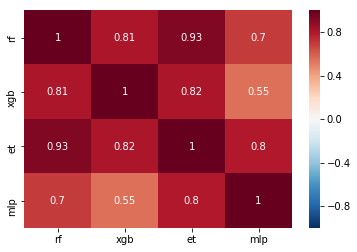

In [15]:
# use XGBoost to blend the base models
    
lvl1_predictions = pd.DataFrame()

lvl1_predictions["rf"] = get_base_predictions(forest)
lvl1_predictions["xgb"] = get_base_predictions(gbm)
# lvl1_predictions["svr"] = get_base_predictions(svr)
lvl1_predictions["et"] = get_base_predictions(et)
lvl1_predictions["mlp"] = get_base_predictions(mlp)



# look at correlation map of base predictions
plt.figure()
zz = lvl1_predictions.corr()
sns.heatmap(zz,annot=True,cmap="RdBu_r",vmin=-1,vmax=1);

# the models are decently correlated with each other. 
# this is not ideal, but that's life

print(lvl1_predictions.head())


Averaged MAE 18.291247


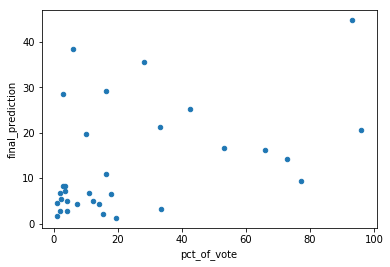

<Figure size 1152x1152 with 0 Axes>

<Figure size 432x288 with 0 Axes>

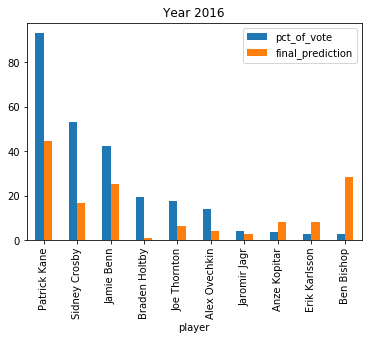

<Figure size 432x288 with 0 Axes>

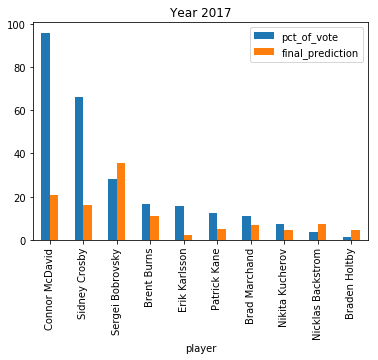

<Figure size 432x288 with 0 Axes>

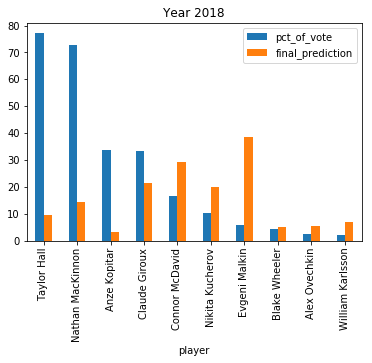

In [16]:
# train the ensemble 
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'max_depth': 7,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
    'nrounds': 350
}

stack = XgbWrapper(seed=SEED,params=xgb_params)

stack.train(lvl1_predictions,y_holdout)

# feature importances, out of curiosity
# print zip(lvl1_predictions.columns,stack.feature_importances)


# prepare input predictions for blender
x_test_lvl2 = pd.DataFrame(columns = {
                                          })

x_test_lvl2["rf"] = forest.predict(x_test)
x_test_lvl2["xgb"] = gbm.predict(x_test)
# x_test_lvl2["svr"] = svr_test_F
x_test_lvl2["et"] = et.predict(x_test)
x_test_lvl2["mlp"] = mlp.predict(x_test)





lvl2_prediction = stack.predict(x_test_lvl2)


print("Averaged MAE %f" % mean_absolute_error(lvl2_prediction,y_test))

test["final_prediction"] = lvl2_prediction


# fig = plt.figure()



test.plot.scatter(x='pct_of_vote',y='final_prediction')

fig = plt.figure(figsize=(16,16))

# g = sns.FacetGrid(test,col="Year",height=6,orientation="h")
# g.map(sns.barplot, 'player','pct_of_vote')
# sns.catplot(x='player', y = 'pct_of_vote',data=test,kind='bar',row='Year',sharex=False,height=14)


# its annoyingly difficult to make a facetgrid to show the three years

for year in [2016,2017,2018]:
    t = test[test['Year']==year]
    fig = plt.figure()
    t[['player','pct_of_vote','final_prediction']].head(10).plot.bar(x='player')
    plt.title("Year %i" % year)

    

# life is hard


Some years, such as 2018, are particularly unkind. After a brief investigation, our model seems to strongly overweigh goals, which is not an unreasonable thing to do. The model just sees the statistics in a vacuum, and has no idea about the team's record during that year, or advanced statistics such as WAR that seek to more directly classify how useful a player was to their team. So there is clearly room for improvement here.